#### *Optimization*

In [ ]:
import sys
sys.path.append('../Utils') 
import configs
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, 
    precision_score, recall_score, classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd
import joblib

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [5]:
# ---------------------------
# 1. Multi-View Dataset (optional if using ImageFolder)
# ---------------------------
# If images are already structured by class folders:
train_dataset = ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
]))

test_dataset = ImageFolder(configs.MULTIVIEW_TEST_DIR, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [6]:
# ---------------------------
# 2. Feature Extractor (ResNet50, frozen)
# ---------------------------
class FeatureExtractor(nn.Module):
    def __init__(self, backbone="resnet18"):
        super().__init__()
        if backbone=="resnet18":
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            self.features = nn.Sequential(*list(model.children())[:-1])
            self.out_dim = model.fc.in_features
        else:
            raise ValueError("Backbone not supported")
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            x = torch.flatten(x, 1)
        return x

extractor = FeatureExtractor("resnet18").to(device).eval()

In [7]:

# ---------------------------
# 3. Feature Extraction Function
# ---------------------------
def extract_features(loader, model, device):
    model.eval()
    features_list, labels_list = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs = imgs.to(device)
            feats = model(imgs)
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
    X = np.vstack(features_list)
    y = np.hstack(labels_list)
    return X, y

In [8]:
train_features, train_labels = extract_features(train_loader, extractor, device)
test_features, test_labels = extract_features(test_loader, extractor, device)
print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")


  0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:30<00:00,  1.45s/it]

Train Features: (2785, 512), Train Labels: (2785,)
Test Features: (670, 512), Test Labels: (670,)


In [9]:
# ---------------------------
# 5. Optimized RBF-SVM Pipeline with Grid Search
# ---------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # redundant if you already scaled, but keeps pipeline flexible
    ('dim_reducer',PCA(n_components=0.95, random_state=42) ),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))
])

param_grid = {
    'svm__C': np.logspace(0, 5, 10),         # [1, 3.16, ..., 100000]
    'svm__gamma': np.logspace(-6, -1, 10),   # [1e-6 ... 0.1]
    'svm__kernel': ['rbf']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(train_features, train_labels)
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_



Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END ......svm__C=1.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.7s
[CV] END svm__C=1.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.9s
[CV] END ......svm__C=1.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.0s
[CV] END ......svm__C=1.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.0s
[CV] END svm__C=1.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   4.1s
[CV] END svm__C=1.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END ......svm__C=1.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.1s
[CV] END ......svm__C=1.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.1s
[CV] END svm__C=1.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   3.1s
[CV] END svm__C=1.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   3.2s
[CV] END svm__C=1.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   3.4s
[CV] END svm__C=1.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.7s
[CV] END svm__C=1.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.8s
[CV] END svm__C=1.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   4.0s
[CV] END svm__C=1.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.9s
[CV] END svm__C=1.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.6s
[CV] END svm__C=1.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.2s
[CV] END svm__C=1.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.9s
[CV] END svm__C=1.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=1.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.9s
[CV] END svm__C=1.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=1.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   3.0s
[CV] END svm__C=1.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=1.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=1.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=1.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=1.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=1.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.0s
[CV] END svm__C=1.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   3.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.0s
[CV] END svm__C=1.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=1.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=1.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=1.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END ........svm__C=1.0, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END ........svm__C=1.0, svm__gamma=0.1, svm__kernel=rbf; total time=   4.1s
[CV] END ........svm__C=1.0, svm__gamma=0.1, svm__kernel=rbf; total time=   4.1s
[CV] END ........svm__C=1.0, svm__gamma=0.1, svm__kernel=rbf; total time=   4.3s
[CV] END ........svm__C=1.0, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=3.5938136638046276, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.7s
[CV] END svm__C=3.5938136638046276, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.6s
[CV] END svm__C=3.5938136638046276, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.3s
[CV] END svm__C=3.5938136638046276, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.6s
[CV] END svm__C=3.5938136638046276, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=3.5938136638046276, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.5s
[CV] END svm__C=3.5938136638046276, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=3.5938136638046276, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   3.0s
[CV] END svm__C=3.5938136638046276, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.0s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   3.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.0s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.7s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.1, svm__kernel=rbf; total time=   4.1s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.1, svm__kernel=rbf; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=3.5938136638046276, svm__gamma=0.1, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=3.5938136638046276, svm__gamma=0.1, svm__kernel=rbf; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.7s
[CV] END svm__C=12.91549665014884, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.9s
[CV] END svm__C=12.91549665014884, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=12.91549665014884, svm__gamma=1e-06, svm__kernel=rbf; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.5s
[CV] END svm__C=12.91549665014884, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.5s
[CV] END svm__C=12.91549665014884, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.6s
[CV] END svm__C=12.91549665014884, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=12.91549665014884, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=12.91549665014884, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.2s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.0s
[CV] END svm__C=12.91549665014884, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.0s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=12.91549665014884, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=12.91549665014884, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=12.91549665014884, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s
[CV] END svm__C=12.91549665014884, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=12.91549665014884, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=12.91549665014884, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=12.91549665014884, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.1, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=12.91549665014884, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=12.91549665014884, svm__gamma=0.1, svm__kernel=rbf; total time=   4.8s
[CV] END svm__C=12.91549665014884, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=12.91549665014884, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.2s
[CV] END svm__C=46.4158883361278, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.6s
[CV] END svm__C=46.4158883361278, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.0s
[CV] END svm__C=46.4158883361278, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=46.4158883361278, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=46.4158883361278, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.9s
[CV] END svm__C=46.4158883361278, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=46.4158883361278, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.2s
[CV] END svm__C=46.4158883361278, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=46.4158883361278, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=46.4158883361278, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=46.4158883361278, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=46.4158883361278, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=46.4158883361278, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=46.4158883361278, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=46.4158883361278, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=46.4158883361278, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=46.4158883361278, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=46.4158883361278, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s
[CV] END svm__C=46.4158883361278, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=46.4158883361278, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s
[CV] END svm__C=46.4158883361278, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=46.4158883361278, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.7s
[CV] END svm__C=46.4158883361278, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.1, svm__kernel=rbf; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=46.4158883361278, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=166.81005372000593, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=46.4158883361278, svm__gamma=0.1, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=166.81005372000593, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=1e-06, svm__kernel=rbf; total time=   3.0s
[CV] END svm__C=46.4158883361278, svm__gamma=0.1, svm__kernel=rbf; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.9s
[CV] END svm__C=46.4158883361278, svm__gamma=0.1, svm__kernel=rbf; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=166.81005372000593, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=166.81005372000593, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=166.81005372000593, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=166.81005372000593, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=166.81005372000593, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=166.81005372000593, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=166.81005372000593, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=166.81005372000593, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=166.81005372000593, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=166.81005372000593, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=166.81005372000593, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.0s
[CV] END svm__C=166.81005372000593, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=166.81005372000593, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=166.81005372000593, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=166.81005372000593, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=166.81005372000593, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.6s
[CV] END svm__C=166.81005372000593, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=599.4842503189409, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.0s
[CV] END svm__C=599.4842503189409, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=599.4842503189409, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.1, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=166.81005372000593, svm__gamma=0.1, svm__kernel=rbf; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=166.81005372000593, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=166.81005372000593, svm__gamma=0.1, svm__kernel=rbf; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=599.4842503189409, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=599.4842503189409, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=599.4842503189409, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=599.4842503189409, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=599.4842503189409, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=599.4842503189409, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=599.4842503189409, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=599.4842503189409, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=599.4842503189409, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=599.4842503189409, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=599.4842503189409, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=599.4842503189409, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=599.4842503189409, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=599.4842503189409, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=599.4842503189409, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.8s
[CV] END svm__C=599.4842503189409, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s
[CV] END svm__C=599.4842503189409, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s
[CV] END svm__C=599.4842503189409, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.6s
[CV] END svm__C=599.4842503189409, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.7s
[CV] END svm__C=599.4842503189409, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=599.4842503189409, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=2154.4346900318847, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.0s
[CV] END svm__C=2154.4346900318847, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=2154.4346900318847, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=2154.4346900318847, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=599.4842503189409, svm__gamma=0.1, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=599.4842503189409, svm__gamma=0.1, svm__kernel=rbf; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.1, svm__kernel=rbf; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=599.4842503189409, svm__gamma=0.1, svm__kernel=rbf; total time=   4.6s
[CV] END svm__C=2154.4346900318847, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.4s
[CV] END svm__C=2154.4346900318847, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=2154.4346900318847, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=2154.4346900318847, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=2154.4346900318847, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=2154.4346900318847, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=2154.4346900318847, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=2154.4346900318847, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=2154.4346900318847, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.8s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.8s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=7742.636826811277, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.1, svm__kernel=rbf; total time=   4.1s
[CV] END svm__C=7742.636826811277, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=7742.636826811277, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=7742.636826811277, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=2154.4346900318847, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=2154.4346900318847, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=7742.636826811277, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.4s
[CV] END svm__C=7742.636826811277, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=7742.636826811277, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=7742.636826811277, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=7742.636826811277, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=7742.636826811277, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=7742.636826811277, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=7742.636826811277, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=7742.636826811277, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=7742.636826811277, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=7742.636826811277, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=7742.636826811277, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=7742.636826811277, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   3.1s
[CV] END svm__C=7742.636826811277, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.9s
[CV] END svm__C=7742.636826811277, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.0s
[CV] END svm__C=7742.636826811277, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.0s
[CV] END svm__C=7742.636826811277, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=7742.636826811277, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=7742.636826811277, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=27825.59402207126, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=27825.59402207126, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=7742.636826811277, svm__gamma=0.1, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=7742.636826811277, svm__gamma=0.1, svm__kernel=rbf; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.1, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=7742.636826811277, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=7742.636826811277, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=27825.59402207126, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=27825.59402207126, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=27825.59402207126, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=27825.59402207126, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=27825.59402207126, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=27825.59402207126, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.2s
[CV] END svm__C=27825.59402207126, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.2s
[CV] END svm__C=27825.59402207126, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.7s
[CV] END svm__C=27825.59402207126, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.7s
[CV] END svm__C=27825.59402207126, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=27825.59402207126, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=27825.59402207126, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.0s
[CV] END svm__C=27825.59402207126, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.9s
[CV] END svm__C=27825.59402207126, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.8s
[CV] END svm__C=27825.59402207126, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s
[CV] END svm__C=27825.59402207126, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=27825.59402207126, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=27825.59402207126, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.6s
[CV] END svm__C=27825.59402207126, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=27825.59402207126, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.8s
[CV] END svm__C=27825.59402207126, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END .svm__C=100000.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.9s
[CV] END .svm__C=100000.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.7s
[CV] END .svm__C=100000.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.9s
[CV] END .svm__C=100000.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   1.9s
[CV] END .svm__C=100000.0, svm__gamma=1e-06, svm__kernel=rbf; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.1, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=27825.59402207126, svm__gamma=0.1, svm__kernel=rbf; total time=   4.2s
[CV] END svm__C=27825.59402207126, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=27825.59402207126, svm__gamma=0.1, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=27825.59402207126, svm__gamma=0.1, svm__kernel=rbf; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=100000.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=100000.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.5s
[CV] END svm__C=100000.0, svm__gamma=3.5938136638046257e-06, svm__kernel=rbf; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.0s
[CV] END svm__C=100000.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.2s
[CV] END svm__C=100000.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=1.2915496650148827e-05, svm__kernel=rbf; total time=   3.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=100000.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.6s
[CV] END svm__C=100000.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.4s
[CV] END svm__C=100000.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.3s
[CV] END svm__C=100000.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=100000.0, svm__gamma=4.641588833612782e-05, svm__kernel=rbf; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.0001668100537200059, svm__kernel=rbf; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=100000.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.8s
[CV] END svm__C=100000.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s
[CV] END svm__C=100000.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   2.1s
[CV] END svm__C=100000.0, svm__gamma=0.0005994842503189409, svm__kernel=rbf; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.6s
[CV] END svm__C=100000.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.0021544346900318843, svm__kernel=rbf; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   3.9s
[CV] END svm__C=100000.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s
[CV] END svm__C=100000.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.4s
[CV] END svm__C=100000.0, svm__gamma=0.007742636826811277, svm__kernel=rbf; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.6s
[CV] END svm__C=100000.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.5s
[CV] END svm__C=100000.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END svm__C=100000.0, svm__gamma=0.02782559402207126, svm__kernel=rbf; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END ...svm__C=100000.0, svm__gamma=0.1, svm__kernel=rbf; total time=   3.6s
[CV] END ...svm__C=100000.0, svm__gamma=0.1, svm__kernel=rbf; total time=   3.5s
[CV] END ...svm__C=100000.0, svm__gamma=0.1, svm__kernel=rbf; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END ...svm__C=100000.0, svm__gamma=0.1, svm__kernel=rbf; total time=   3.4s
[CV] END ...svm__C=100000.0, svm__gamma=0.1, svm__kernel=rbf; total time=   3.4s
Best Parameters: {'svm__C': np.float64(3.5938136638046276), 'svm__gamma': np.float64(0.0021544346900318843), 'svm__kernel': 'rbf'}



Optimized RBF-SVM Metrics:
Accuracy: 0.7179
Balanced Accuracy: 0.6705
F1 Score: 0.7133
Precision: 0.7219
Recall: 0.7179
              precision    recall  f1-score   support

         Ash       0.62      0.57      0.60        35
       Beech       0.76      0.83      0.79       160
 Douglas Fir       0.72      0.72      0.72       180
         Oak       1.00      0.40      0.57        20
        Pine       0.90      0.72      0.80        25
     Red Oak       0.70      0.87      0.78        95
      Spruce       0.66      0.58      0.62       155

    accuracy                           0.72       670
   macro avg       0.77      0.67      0.70       670
weighted avg       0.72      0.72      0.71       670



/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

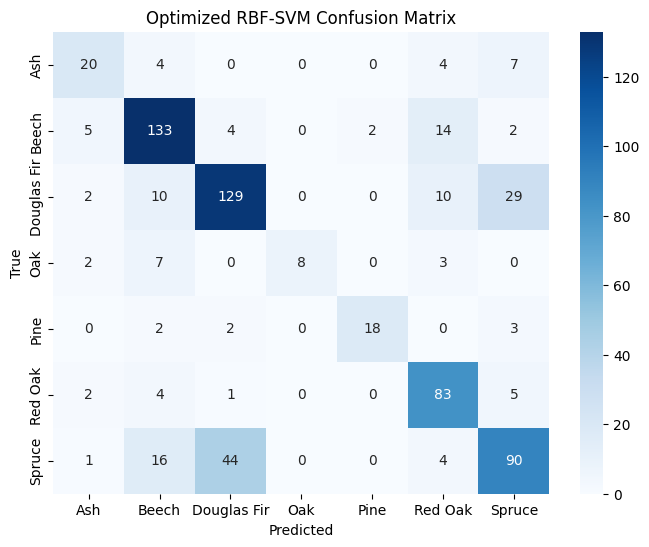

In [10]:
# ---------------------------
# 6. Predictions & Metrics
# ---------------------------
pred_labels = best_model.predict(test_features)	

accuracy = accuracy_score(test_labels, pred_labels)
balanced_acc = balanced_accuracy_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels, average='weighted')
precision = precision_score(test_labels, pred_labels, average='weighted')
recall = recall_score(test_labels, pred_labels, average='weighted')

print("\nOptimized RBF-SVM Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification report
print(classification_report(test_labels, pred_labels, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Optimized RBF-SVM Confusion Matrix')
plt.show()


## Optimization

In [11]:
# ---------------------------
# 5. Optimized RBF-SVM Pipeline
# ---------------------------
from sklearn.model_selection import StratifiedKFold

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("svm", SVC(kernel="rbf",
                probability=True,
                class_weight="balanced",
                random_state=42))
])

param_grid = {
    "pca": [PCA(n_components=0.95, random_state=42), None],   # try with & without PCA
    "svm__C": np.logspace(-1, 6, 12),        # 0.1 … 1e6
    "svm__gamma": np.logspace(-7, 0, 12),    # 1e-7 … 1
    "svm__shrinking": [True, False]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring={"acc": "accuracy", "f1_weighted": "f1_weighted"},
    refit="f1_weighted",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train_features, train_labels)

print("Best params:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=   3.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   3.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   3.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   4.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=True; total time=   5.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=True; total time=   5.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=True; total time=   5.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=False; total time=   5.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.1, svm__gamma=1.0, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=True; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1e-07, svm__shrinking=False; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   3.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   3.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   3.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=0.43287612810830584, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=False; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1e-07, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=True; total time=   5.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1.8738174228603839, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1e-07, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   3.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=8.111308307896872, svm__gamma=1.0, svm__shrinking=False; total time=   5.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1e-07, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   3.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=True; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=35.11191734215131, svm__gamma=1.0, svm__shrinking=False; total time=   5.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=True; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=False; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=False; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1e-07, svm__shrinking=False; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=True; total time=   5.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=151.99110829529332, svm__gamma=1.0, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=True; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=True; total time=   3.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=True; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=True; total time=   3.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=False; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=False; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=False; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=False; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1e-07, svm__shrinking=False; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   1.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=False; total time=   5.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=True; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=657.9332246575682, svm__gamma=1.0, svm__shrinking=False; total time=   5.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=True; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=True; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=True; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=True; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=False; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=False; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1e-07, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   2.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=True; total time=   5.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=True; total time=   5.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=True; total time=   5.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=True; total time=   5.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=True; total time=   5.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=False; total time=   5.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=False; total time=   5.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=2848.035868435799, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=True; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=True; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1e-07, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=True; total time=   5.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=False; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=True; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=12328.467394420659, svm__gamma=1.0, svm__shrinking=False; total time=   5.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decompo

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1e-07, svm__shrinking=False; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   2.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   3.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   3.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=True; total time=   5.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=True; total time=   5.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=53366.99231206313, svm__gamma=1.0, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=True; total time=   1.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=True; total time=   1.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=True; total time=   1.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=False; total time=   2.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=False; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1e-07, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   1.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   3.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   3.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   5.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   6.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   7.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   6.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   6.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=   6.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.4s


b/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: invalid value encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=True; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=True; total time=   5.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=True; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=False; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=False; total time=   5.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=False; total time=   5.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=231012.9700083158, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=True; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=False; total time=   3.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=False; total time=   3.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=False; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=False; total time=   3.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1e-07, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=True; total time=   3.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   5.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   6.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   6.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   6.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=4.3287612810830616e-07, svm__shrinking=False; total time=   5.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   5.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=True; total time=   5.5s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   5.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   6.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   6.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   6.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=True; total time=   6.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   9.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=   9.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=  10.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=  10.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.873817422860383e-06, svm__shrinking=False; total time=  10.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=True; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=  10.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   3.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=3.511191734215127e-05, svm__shrinking=False; total time=   4.0s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=  10.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=  11.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=  10.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   1.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=8.111308307896873e-06, svm__shrinking=False; total time=  11.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.4s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0001519911082952933, svm__shrinking=False; total time=   2.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=True; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   1.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.0006579332246575682, svm__shrinking=False; total time=   2.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=True; total time=   3.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   3.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.002848035868435799, svm__shrinking=False; total time=   2.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.7s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.3s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.012328467394420659, svm__shrinking=False; total time=   4.8s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=True; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.0s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.05336699231206313, svm__shrinking=False; total time=   5.2s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.7s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.5s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.6s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=0.2310129700083158, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=True; total time=   5.2s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=True; total time=   5.1s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=False; total time=   4.9s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=True; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=False; total time=   5.4s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=False; total time=   5.6s
[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=False; total time=   5.3s


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/ayou

[CV] END pca=PCA(n_components=0.95, random_state=42), svm__C=1000000.0, svm__gamma=1.0, svm__shrinking=False; total time=   5.7s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=  11.4s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=  12.2s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=  12.4s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=  12.5s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=True; total time=  12.7s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=  12.2s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=  11.9s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=  11.5s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=False; total time=  11.8s
[CV] END pca=None, svm__C=0.1, svm__gamma=1e-07, svm__shrinking=Fa


Optimized RBF-SVM Metrics:
Accuracy: 0.7134
Balanced Accuracy: 0.6547
F1 Score: 0.7092
Precision: 0.7098
Recall: 0.7134
              precision    recall  f1-score   support

         Ash       0.56      0.51      0.54        35
       Beech       0.78      0.79      0.78       160
 Douglas Fir       0.73      0.75      0.74       180
         Oak       0.50      0.35      0.41        20
        Pine       0.82      0.72      0.77        25
     Red Oak       0.71      0.87      0.78        95
      Spruce       0.66      0.59      0.62       155

    accuracy                           0.71       670
   macro avg       0.68      0.65      0.66       670
weighted avg       0.71      0.71      0.71       670



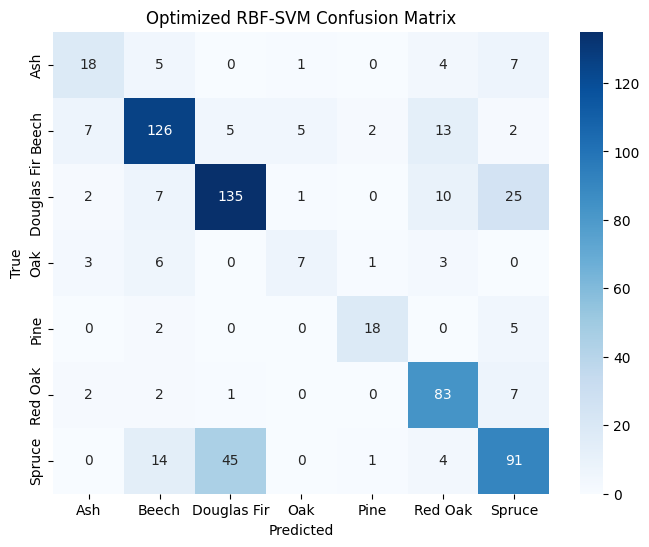

In [ ]:
# ---------------------------
# 6. Predictions & Metrics
# ---------------------------
pred_labels = best_model.predict(test_features)

accuracy = accuracy_score(test_labels, pred_labels)
balanced_acc = balanced_accuracy_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels, average='weighted')
precision = precision_score(test_labels, pred_labels, average='weighted')
recall = recall_score(test_labels, pred_labels, average='weighted')

print("\nOptimized RBF-SVM Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification report
print(classification_report(test_labels, pred_labels, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Optimized RBF-SVM Confusion Matrix')
plt.show()
